In [2]:
import pandas as pd
import torch
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import numpy as np

class MnistDataset(Dataset):
    train_data = pd.read_csv("mnist_train.csv")
    train_data =train_data.to_numpy()
    # read csv
    def __init__(self):
        super().__init__()
        
    def __len__(self):
        return len(MnistDataset.train_data)
    def __getitem__(self, index):
        return torch.tensor(MnistDataset.train_data[index,1:]/255,dtype=torch.float32)
        
    def plot_image(self,n):
        data = MnistDataset.train_data[n,1:].reshape(28,28)
        plt.figure(figsize=(3,3))
        plt.imshow(data)



In [3]:
from torch.optim import SGD,Adam
from torch.nn import MSELoss,BCELoss

class D(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.model = torch.nn.Sequential(
            torch.nn.Linear(784,200),
            torch.nn.LeakyReLU(0.02),
            torch.nn.LayerNorm(200),
            torch.nn.Linear(200,1),
            torch.nn.Sigmoid(),
        )
        self.optimizer = Adam(self.parameters(),lr=0.0001)
        self.loss_fn = BCELoss()
        self.loss_hist = []
    
    def forward(self,x):
        return self.model(x)

    def train(self,x,label):
        self.optimizer.zero_grad()
        y_pred = self.model(x)
        loss = self.loss_fn(y_pred,label)
        loss.backward()
        self.optimizer.step()

        self.loss_hist.append(loss.item())
    
    def visualize(self):
        plt.figure(figsize=(4,4))
        plt.scatter(np.arange(1,len(self.loss_hist)+1),self.loss_hist,s=0.5)
        plt.title('discriminator loss')
        plt.show()    
        


In [4]:
def gen_random(size):
    return torch.randn(size)


In [5]:
class G(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.model = torch.nn.Sequential(
            torch.nn.Linear(100,200),
            torch.nn.LeakyReLU(0.02),
            torch.nn.LayerNorm(200),
            torch.nn.Linear(200,784),
            torch.nn.Sigmoid(),
        )

        self.optimizer = Adam(self.parameters(),lr=0.0001)
        
        self.loss_hist = []

    def forward(self,x):
        return self.model(x)
    
    def train(self,D,x,label):
        self.optimizer.zero_grad()
        fake_pred = self.forward(x)
        y_pred = D(fake_pred)
        loss = D.loss_fn(y_pred,label)
        loss.backward()
        self.optimizer.step()
        
        self.loss_hist.append(loss.item())
    
    def visualize(self):
        plt.figure(figsize=(4,4))
        plt.scatter(np.arange(1,len(self.loss_hist)+1),self.loss_hist,s=0.5)
        plt.title('generator loss')
        plt.show()
    
    def visualize_8img(self,x):
        fake_pred = self.forward(x).detach().numpy() # size(16,28*28)
        fake_pred = fake_pred.reshape((-1,28,28)).transpose((1,0,2)).reshape((28,-1))

        plt.figure(figsize=(16,2))
        plt.title('generator prediction')
        plt.imshow(fake_pred, cmap='Blues')
        

In [6]:
mnist_dataset = MnistDataset()

In [7]:
dataloader = DataLoader(mnist_dataset,1)
d = D()
g= G()



for i,data in enumerate(dataloader): #enumerate 가능한가? 몇 epoch인지 출력하고 싶은데

    print(data.shape)
    break
    d.train(data.reshape(784),torch.tensor([1.0],dtype=torch.float32))
    d.train(g(gen_random(100)).detach(),torch.tensor([0.0],dtype=torch.float32))
    g.train(d,gen_random(100),torch.tensor([1.0],dtype=torch.float32))

    if i%(100)==0:
        print(f"i {i}")   
        if (d.loss_hist):
            print(f'g loss {g.loss_hist[-1]}')
            print(f'd loss {d.loss_hist[-1]}')

torch.Size([1, 784])


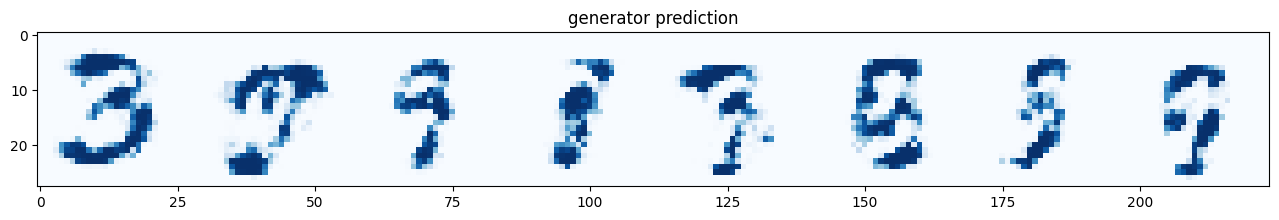

In [ ]:
g.visualize_8img(gen_random((8,100)))

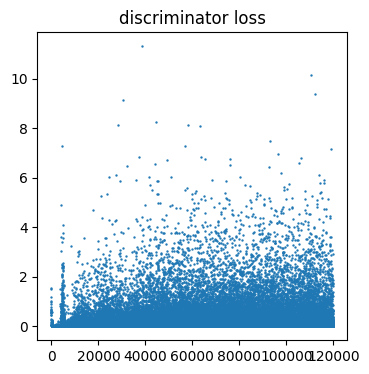

In [8]:
d.visualize()

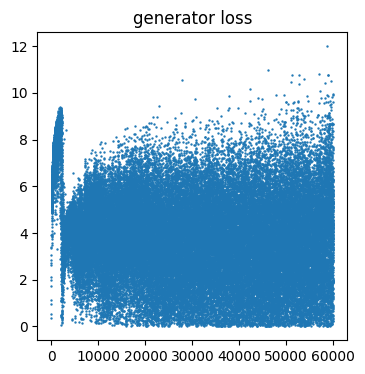

In [9]:
g.visualize()